In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
yahooResponse = requests.get('https://query1.finance.yahoo.com/v8/finance/chart/AAPL?region=US&lang=en-US&includePrePost=false&interval=1h&useYfid=true&range=1y&corsDomain=finance.yahoo.com&.tsrc=finance')


In [3]:
yahooData = yahooResponse.json()['chart']['result'][0]

In [4]:
data = {
          'open': yahooData['indicators']['quote'][0]['open'], 
          'high': yahooData['indicators']['quote'][0]['high'],
          'close': yahooData['indicators']['quote'][0]['close']
}
handledData = pd.DataFrame(data=data, index=pd.to_datetime(np.array(yahooData['timestamp']) * 1000, unit='ms').to_pydatetime())

In [5]:
handledData.dropna(inplace=True)

In [6]:
handledData["change"] = handledData['close'] - handledData['open']
handledData["percent"] = (handledData['close'] * 100)/handledData['open'] - 100

In [7]:
handledData

,open,high,close,change,percent
2020-04-13 14:30:00,66.910004,67.080002,66.991653,0.081650,0.122029
2020-04-13 15:30:00,66.992500,67.275002,67.058975,0.066475,0.099227
2020-04-13 16:30:00,67.052498,67.152496,67.047501,-0.004997,-0.007453
2020-04-13 17:30:00,67.047501,67.447502,67.351250,0.303749,0.453036
2020-04-13 18:30:00,67.351349,67.862503,67.857498,0.506149,0.751506
...,...,...,...,...,...
2021-04-12 18:30:00,131.535004,131.609894,131.309998,-0.225006,-0.171062
2021-04-12 19:30:00,131.309296,131.529999,131.269897,-0.039398,-0.030004
2021-04-13 13:30:00,132.360001,133.690002,133.313004,0.953003,0.720008
2021-04-13 14:30:00,133.319397,133.500000,133.369995,0.050598,0.037953


In [8]:
handledData.describe()

,open,high,close,change,percent
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,110.550832,111.048649,110.546525,-0.004308,0.003249
std,19.866468,19.954748,19.840189,0.726023,0.641201
min,66.750000,67.080002,66.750000,-7.012497,-5.801532
25%,94.317080,94.686876,94.374180,-0.340004,-0.308049
50%,116.685001,117.279900,116.574951,0.010002,0.008523
75%,124.891899,125.460625,124.858749,0.355005,0.345773
max,144.229996,145.080002,144.229996,5.895004,5.159515


## Цена акций apple


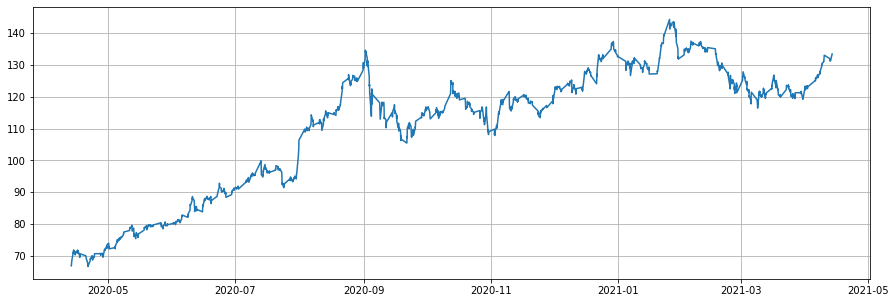

In [9]:
plt.figure(figsize=(15,5))
plt.plot(handledData.index, handledData['close'])
plt.grid(True)

## % изменения в цене(cтационарен)


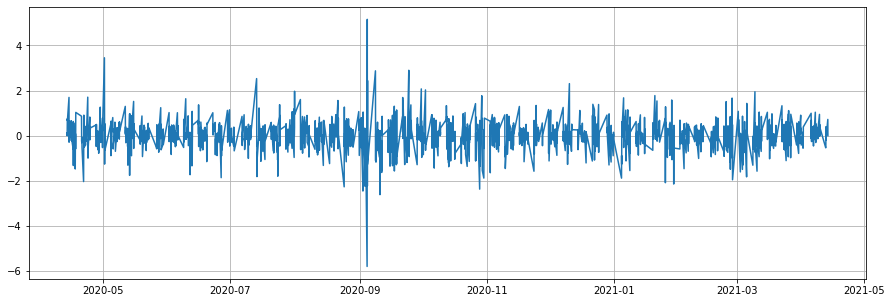

In [10]:
plt.figure(figsize=(15,5))
plt.plot(handledData.index, handledData['percent'])
plt.grid(True)

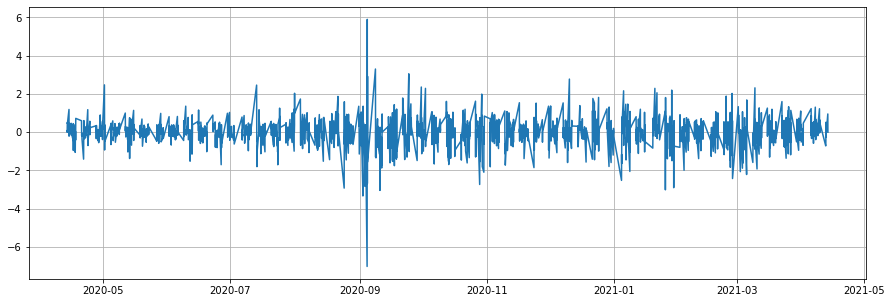

In [11]:
plt.figure(figsize=(15,5))
plt.plot(handledData.index, handledData['change'])
plt.grid(True)

## % изменения в цене за последние 100 часов 

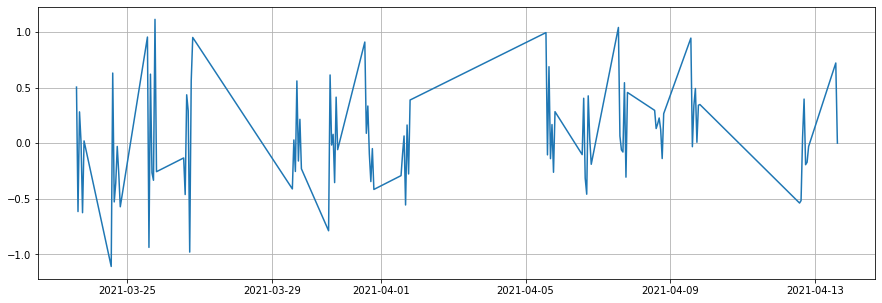

In [12]:
plt.figure(figsize=(15,5))
plt.plot(handledData.index[-100:], handledData['percent'][-100:])
plt.grid(True)

## Анализ ряда по цене акции

In [13]:
shift = -1
handledData['y_open'] = handledData['open'].shift(shift)
handledData[:10]

,open,high,close,change,percent,y_open
2020-04-13 14:30:00,66.910004,67.080002,66.991653,0.081650,0.122029,66.992500
2020-04-13 15:30:00,66.992500,67.275002,67.058975,0.066475,0.099227,67.052498
2020-04-13 16:30:00,67.052498,67.152496,67.047501,-0.004997,-0.007453,67.047501
2020-04-13 17:30:00,67.047501,67.447502,67.351250,0.303749,0.453036,67.351349
2020-04-13 18:30:00,67.351349,67.862503,67.857498,0.506149,0.751506,67.855003
2020-04-13 19:30:00,67.855003,68.367500,68.307503,0.452499,0.666862,70.000000
2020-04-14 13:30:00,70.000000,71.549973,71.187500,1.187500,1.696429,71.181473
2020-04-14 14:30:00,71.181473,71.412498,70.974998,-0.206474,-0.290067,70.967499
2020-04-14 15:30:00,70.967499,71.577499,71.427498,0.459999,0.648183,71.427498
2020-04-14 16:30:00,71.427498,71.633698,71.580002,0.152504,0.213509,71.582497


In [14]:
y_train = handledData['y_open'][:-100]

x_train = handledData[['open','high','close','change']][:-100]

x_test = handledData[['open','high','close','change']][-100:]

y_test = handledData['y_open'][-100:shift]

last_open = handledData['open'][-100:]

In [15]:
import xgboost as xgb

params = {
    'objective': 'reg:squarederror',
    'booster':'gblinear'
}
trees = 1000

dtrain = xgb.DMatrix(x_train, label=y_train)

cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

In [16]:
xgboost_prediction = pd.DataFrame(bst.predict(xgb.DMatrix(x_test)), index=x_test.index).shift(-shift, freq="H")
# xgboost_prediction.iloc[0:-shift, 0] = last_open[0:-shift].values


In [17]:
xgboost_prediction

,0
2021-03-23 15:30:00,123.834610
2021-03-23 16:30:00,122.924492
2021-03-23 17:30:00,123.304222
2021-03-23 18:30:00,123.164619
2021-03-23 19:30:00,122.539139
...,...
2021-04-12 19:30:00,131.205582
2021-04-12 20:30:00,131.184433
2021-04-13 14:30:00,133.433334
2021-04-13 15:30:00,133.253250


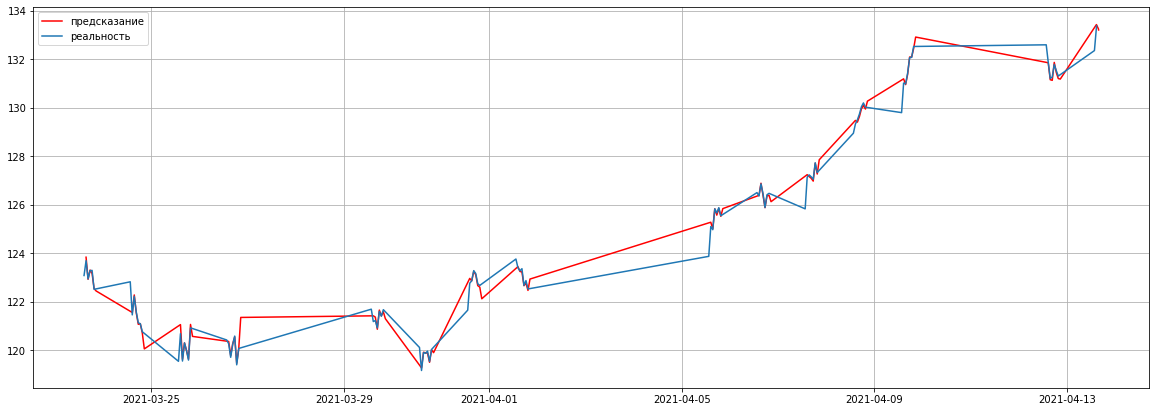

In [18]:
plt.figure(figsize=(20, 7))
plt.plot(xgboost_prediction.index, xgboost_prediction.values, "r", label="предсказание")
plt.plot(last_open.index, last_open.values, label="реальность")
plt.legend(loc="best")
plt.grid(True)

## sklearn

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
lr = LinearRegression()

lr.fit(x_train, y_train)

sklearn_prediction = pd.DataFrame(lr.predict(x_test), index=x_test.index).shift(-shift, freq="H")
# sklearn_prediction.iloc[0:-shift, 0] = last_open[0:-shift].values
sklearn_prediction

,0
2021-03-23 15:30:00,123.742796
2021-03-23 16:30:00,122.975325
2021-03-23 17:30:00,123.323630
2021-03-23 18:30:00,123.326146
2021-03-23 19:30:00,122.566542
...,...
2021-04-12 19:30:00,131.343863
2021-04-12 20:30:00,131.302464
2021-04-13 14:30:00,133.349104
2021-04-13 15:30:00,133.400088


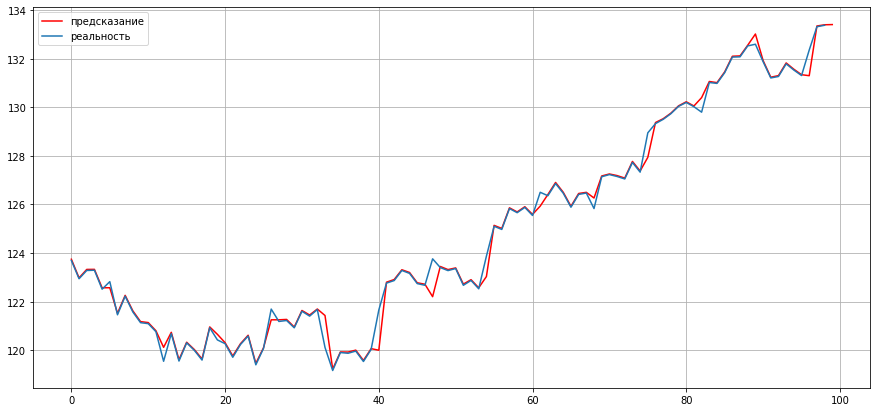

In [21]:
plt.figure(figsize=(15, 7))
plt.plot(sklearn_prediction.values, "r", label="предсказание")
plt.plot(last_open[-shift:].values, label="реальность")
plt.legend(loc="best")
plt.grid(True)

In [22]:
handledData[['open','high','close','change', 'y_open']][-100:]

,open,high,close,change,y_open
2021-03-23 14:30:00,123.080101,124.239998,123.699997,0.619896,123.690903
2021-03-23 15:30:00,123.690903,123.760002,122.931099,-0.759804,122.940002
2021-03-23 16:30:00,122.940002,123.614998,123.285500,0.345497,123.279999
2021-03-23 17:30:00,123.279999,123.345001,123.294998,0.014999,123.290001
2021-03-23 18:30:00,123.290001,123.430000,122.519997,-0.770004,122.510002
...,...,...,...,...,...
2021-04-12 18:30:00,131.535004,131.609894,131.309998,-0.225006,131.309296
2021-04-12 19:30:00,131.309296,131.529999,131.269897,-0.039398,132.360001
2021-04-13 13:30:00,132.360001,133.690002,133.313004,0.953003,133.319397
2021-04-13 14:30:00,133.319397,133.500000,133.369995,0.050598,133.380005


In [23]:
sklearn_prediction

,0
2021-03-23 15:30:00,123.742796
2021-03-23 16:30:00,122.975325
2021-03-23 17:30:00,123.323630
2021-03-23 18:30:00,123.326146
2021-03-23 19:30:00,122.566542
...,...
2021-04-12 19:30:00,131.343863
2021-04-12 20:30:00,131.302464
2021-04-13 14:30:00,133.349104
2021-04-13 15:30:00,133.400088


## Выделим в отельную функцую предсказание фактора

In [24]:
def factor_prediction_model(factor_name, data, shift=-1):
    y_name = 'y_'+factor_name
    data[y_name] = data[factor_name].shift(shift)

    y_train = data[y_name][:shift]

    x_train = data[['open','high','close','change']][:shift]

    params = {
        'objective': 'reg:squarederror',
        'booster':'gblinear'
    }
    trees = 1000

    dtrain = xgb.DMatrix(x_train, label=y_train)

    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    model = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # model = LinearRegression()

    # model.fit(x_train, y_train)

    return model, data

In [25]:
open_model, open_data = factor_prediction_model('open', handledData)
high_model, high_data = factor_prediction_model('high', handledData)
close_model, close_data = factor_prediction_model('close', handledData)
change_model, change_data = factor_prediction_model('change', handledData)
change_data

,open,high,close,change,percent,y_open,y_high,y_close,y_change
2020-04-13 14:30:00,66.910004,67.080002,66.991653,0.081650,0.122029,66.992500,67.275002,67.058975,0.066475
2020-04-13 15:30:00,66.992500,67.275002,67.058975,0.066475,0.099227,67.052498,67.152496,67.047501,-0.004997
2020-04-13 16:30:00,67.052498,67.152496,67.047501,-0.004997,-0.007453,67.047501,67.447502,67.351250,0.303749
2020-04-13 17:30:00,67.047501,67.447502,67.351250,0.303749,0.453036,67.351349,67.862503,67.857498,0.506149
2020-04-13 18:30:00,67.351349,67.862503,67.857498,0.506149,0.751506,67.855003,68.367500,68.307503,0.452499
...,...,...,...,...,...,...,...,...,...
2021-04-12 18:30:00,131.535004,131.609894,131.309998,-0.225006,-0.171062,131.309296,131.529999,131.269897,-0.039398
2021-04-12 19:30:00,131.309296,131.529999,131.269897,-0.039398,-0.030004,132.360001,133.690002,133.313004,0.953003
2021-04-13 13:30:00,132.360001,133.690002,133.313004,0.953003,0.720008,133.319397,133.500000,133.369995,0.050598
2021-04-13 14:30:00,133.319397,133.500000,133.369995,0.050598,0.037953,133.380005,133.380005,133.380005,0.000000


## Анализ ряда по изменению акции (Доработать)

In [26]:
x_change_test = change_data[['open','high','close','change']][-100:]

y_change_test = change_data['y_change'][-100:]

xgboost_prediction_changes = pd.DataFrame(change_model.predict(xgb.DMatrix(x_change_test)), index=x_change_test.index).shift(-shift, freq="H")
# xgboost_prediction_changes = pd.DataFrame(change_model.predict(x_change_test), index=x_change_test.index).shift(-shift, freq="H")
xgboost_prediction_changes

,0
2021-03-23 15:30:00,-0.038842
2021-03-23 16:30:00,-0.024387
2021-03-23 17:30:00,-0.035075
2021-03-23 18:30:00,-0.031656
2021-03-23 19:30:00,-0.023455
...,...
2021-04-12 19:30:00,-0.047738
2021-04-12 20:30:00,-0.049358
2021-04-13 14:30:00,-0.063481
2021-04-13 15:30:00,-0.054797


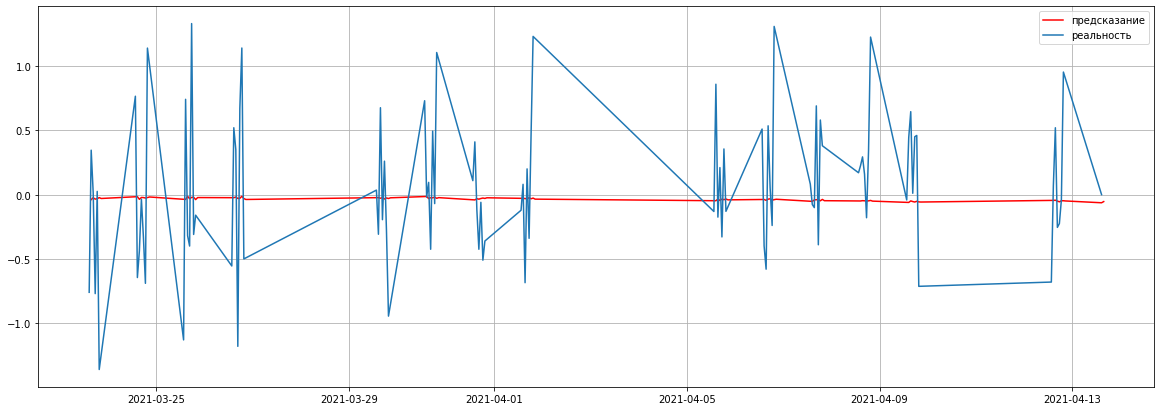

In [27]:
plt.figure(figsize=(20, 7))
plt.plot(xgboost_prediction_changes.index, xgboost_prediction_changes.values, "r", label="предсказание")
plt.plot(y_change_test.index, y_change_test.values, label="реальность")
plt.legend(loc="best")
plt.grid(True)

## Предсказываем на день 

In [28]:
handledData[['open']].tail(1).values

array([[133.38000488]])

predicted_values = [[
    handledData[['open']].tail(1).values[0][0],
    handledData[['high']].tail(1).values[0][0],
    handledData[['close']].tail(1).values[0][0],
    handledData[['change']].tail(1).values[0][0]
]
]
for i in range(24):
#     predicted_open = open_model.predict(xgb.DMatrix(handledData[['open','high','close','change']].tail(1)))[0]
#     predicted_high = high_model.predict(xgb.DMatrix(handledData[['open','high','close','change']].tail(1)))[0]
#     predicted_close = close_model.predict(xgb.DMatrix(handledData[['open','high','close','change']].tail(1)))[0]
    last_elem = predicted_values[-1]
    print(last_elem)
    print(np.array(last_elem))
    predicted_open = open_model.predict(xgb.DMatrix(np.array(last_elem)))[0]
    predicted_high = high_model.predict(xgb.DMatrix(last_elem))[0]
    predicted_close = close_model.predict(xgb.DMatrix(last_elem))[0]
    
    predicted_change = predicted_close - predicted_open
    new_value = [{'open': predicted_open, 'high': predicted_high, 'close': predicted_close, 'change': predicted_change}]
    handledData.append(pd.DataFrame(new_value))
    predicted_values.append({'open': predicted_open, 'high': predicted_high, 'close': predicted_close, 'change': predicted_change})
predicted_values

In [29]:
import quandl

quandl.ApiConfig.api_key = "9FaFE8zkyciYXxggt_nx"

data = quandl.get("WIKI/AAPL")

In [30]:
data_request_news = {"requests":
                     {"g0":
                      {"resource":"StreamService","operation":"read","params":
                       {"ui":
                        {"comments_offnet":True,
                         "editorial_featured_count":1,"image_quality_override":True,"link_out_allowed":True,"needtoknow_template":"filmstrip","ntk_bypassA3c":True,"pubtime_maxage":0,"relative_links":True,"show_comment_count":True,"smart_crop":True,"storyline_count":2,"storyline_enabled":True,"storyline_min":2,"summary":True,"thumbnail_size":100,
                         "tiles":{"allowPartialRows":True,"doubleTallStart":0,"featured_label":False,"gradient":False,"height":175,"resizeImages":False,
                                  "textOnly":[{"backgroundColor":"#fff","foregroundColor":"#000"}],
                                  "width_max":300,"width_min":200},"view":"mega",
                         "editorial_content_count":6,"enable_lead_fallback_image":True,
                         "finance_upsell_threshold":4},"category":"YFINANCE:AAPL","forceJpg":True,
                        "releasesParams":{"limit":20,"offset":0},
                        "ncpParams":{"query":{"namespace":"finance","id":"tickers-pressrelease-stream","version":"v1","listAlias":"finance-US-en-US-ticker-pressrelease"},
                                     "body":{"gqlVariables":{"tickerStream":{"pagination":{"requestedCount":10,"contentOverrides":
                                                                                           {"8fd070cb-8e2a-3d6f-a8b5-ab5d8308e037":{"list":"ee9a71c0-d3f8-11e9-aff7-e24e68c3a35b"},"aa410f73-9897-39c3-9e2c-dcafbff8204e":{"list":"ee9a71c0-d3f8-11e9-aff7-e24e68c3a35b"},
                                                                                            "433a1c80-e8bb-3968-a2ab-52ad431f981e":{"list":"ee9a71c0-d3f8-11e9-aff7-e24e68c3a35b"},
                                                                                            "98125fe9-a0e0-3ef1-81d7-6f911485e758":{"list":"ee9a71c0-d3f8-11e9-aff7-e24e68c3a35b"},
                                                                                            "3dff0eb6-03fa-30ab-b8f8-f54889c66ef4":{"list":"ee9a71c0-d3f8-11e9-aff7-e24e68c3a35b"},
                                                                                            "f27ebea9-4a42-3218-8804-94a7d39e5829":{"list":"ee9a71c0-d3f8-11e9-aff7-e24e68c3a35b"}},
                                                                                           "remainingCount":6,"geminiToken":"{\"geminiDedupeToken\":\"CjoIjex1ENqlnpr43IWgBxjkhN7pqa-x3mYg8JKBgvum37ukASoVR2VvcmdldG93biBVbml2ZXJzaXR5Ci0IgZdzELSf-I70gofOKBj5nuPB-57x3O0BIJPD5vOnkPOpPioITGVnYWN5RlgSEzkwMjA1MDQ5MjkxNzA1MzQyNjMYAiCai9QC\",\"adsStartIndex\":\"3\"}","uuids":"3dff0eb6-03fa-30ab-b8f8-f54889c66ef4:STORY,f27ebea9-4a42-3218-8804-94a7d39e5829:STORY,433a1c80-e8bb-3968-a2ab-52ad431f981e:STORY,8fd070cb-8e2a-3d6f-a8b5-ab5d8308e037:STORY,98125fe9-a0e0-3ef1-81d7-6f911485e758:STORY,aa410f73-9897-39c3-9e2c-dcafbff8204e:STORY"}}}}},
                        "offnet":{"include_lcp":True,"use_preview":True,"url_scheme":"domain"},"useNCP":True,"video":{"enable_video_enrichment":True},"ads":{"ad_polices":True,"contentType":"video/mp4,application/x-shockwave-flash,application/vnd.apple.mpegurl","count":25,"enableFlashSale":True,"enableGeminiDealsWithoutBackground":True,"frequency":4,"geminiPromotionsEnabled":True,"generic_viewability":True,"inline_video":True,"partial_viewability":True,"pu":"finance.yahoo.com","se":5571994,"spaceid":95993639,"start_index":1,"timeout":0,"type":"STRM,STRM_CONTENT,STRM_VIDEO","useHqImg":True,"useResizedImages":True},"batches":{"pagination":True,"size":10,"timeout":1500,"total":170},"enableAuthorBio":True,"max_exclude":0,"min_count":0,"min_count_error":True,"qsp_views":"pr","service":{"specRetry":{"enabled":False}},"pageContext":{"pageType":"utility","subscribed":"0","enablePremium":"0","eventName":"","topicName":"","category":"press-releases","quoteType":"EQUITY","calendarType":"","screenerType":""},"content_type":"qsp","content_site":"finance"}}},
                     "context":{"feature":"adsMigration,canvassOffnet,ccOnMute,disableCommentsMessage,debouncesearch100,deferDarla,ecmaModern,emptyServiceWorker,enable3pConsent,enableCCPAFooter,enableCMP,enableConsentData,enableFeatureTours,enableFinancialsTemplate,enableFreeFinRichSearch,enableGuceJs,enableGuceJsOverlay,enableNavFeatureCue,enableNewResearchInsights,enablePfSummaryForEveryone,enablePremiumSingleCTA,enablePrivacyUpdate,enableRebranding,enableStreamDebounce,enableTheming,enableUpgradeLeafPage,enableVideoURL,enableXrayNcp,enableXrayNcpInModal,enableXrayTickerEntities,enableYahooSans,enableYodleeErrorMsgCriOS,ncpListStream,ncpPortfolioStream,ncpQspStream,ncpStream,ncpStreamIntl,ncpTopicStream,newContentAttribution,newLogo,oathPlayer,optimizeSearch,relatedVideoFeature,threeAmigos,waferHeader,useNextGenHistory,videoNativePlaylist,sunsetMotif2,enableBrokerCenterBannerQSP,enableUserPrefAPI,livecoverage,darlaFirstRenderingVisible,enableAdlite,enableTradeit,enableFeatureBar,enableSearchEnhancement,enableUserSentiment,enableBankrateWidget,enableYodlee,canvassReplies,enablePremiumFinancials,enableInstapage,enableNewResearchFilterMW,showExpiredIdeas,showMorningStar,enableSEOResearchReport,enableSingleRail,enableUpgrade,enableAmexOffer,enhanceAddToWL,article2_csn,sponsoredAds,enableStageAds,enableTradeItLinkBrokerSecondaryPromo,premiumPromoHeader,enableQspPremiumPromoSmall,clientDelayNone,threeAmigosMabEnabled,threeAmigosAdsEnabledAndStreamIndex0,enableRelatedTickers,enableTasteMaker,enableNotification,enableJSErrorBeacon,financeRightRailA20,enableBrokerCenter,enableYahooPlus,enablePremiumUpsell,enableSpotIm,enableSpotImPitcJAC","bkt":["fdw-brokercenter-QSPgraphic","finance-us-dweb-xray-v2chart-upsell-3","openweb-finance-us-nw1-test5-pII","FINAA005","FINAA015","fd-plutus-enh-2"],"crumb":"Uvl2JTAUYao","device":"desktop","intl":"us","lang":"en-US","partner":"none","prid":"03n3005g7b8q8","region":"US","site":"finance","tz":"Europe/Moscow","ver":"0.102.4649","ecma":"modern"}}

response_news = requests.post('https://finance.yahoo.com/_finance_doubledown/api/resource?bkt=fdw-brokercenter-QSPgraphic%2Cfinance-us-dweb-xray-v2chart-upsell-3%2Copenweb-finance-us-nw1-test5-pII%2CFINAA005%2CFINAA015%2Cfd-plutus-enh-2&crumb=Uvl2JTAUYao&device=desktop&ecma=modern&feature=adsMigration%2CcanvassOffnet%2CccOnMute%2CdisableCommentsMessage%2Cdebouncesearch100%2CdeferDarla%2CecmaModern%2CemptyServiceWorker%2Cenable3pConsent%2CenableCCPAFooter%2CenableCMP%2CenableConsentData%2CenableFeatureTours%2CenableFinancialsTemplate%2CenableFreeFinRichSearch%2CenableGuceJs%2CenableGuceJsOverlay%2CenableNavFeatureCue%2CenableNewResearchInsights%2CenablePfSummaryForEveryone%2CenablePremiumSingleCTA%2CenablePrivacyUpdate%2CenableRebranding%2CenableStreamDebounce%2CenableTheming%2CenableUpgradeLeafPage%2CenableVideoURL%2CenableXrayNcp%2CenableXrayNcpInModal%2CenableXrayTickerEntities%2CenableYahooSans%2CenableYodleeErrorMsgCriOS%2CncpListStream%2CncpPortfolioStream%2CncpQspStream%2CncpStream%2CncpStreamIntl%2CncpTopicStream%2CnewContentAttribution%2CnewLogo%2CoathPlayer%2CoptimizeSearch%2CrelatedVideoFeature%2CthreeAmigos%2CwaferHeader%2CuseNextGenHistory%2CvideoNativePlaylist%2CsunsetMotif2%2CenableBrokerCenterBannerQSP%2CenableUserPrefAPI%2Clivecoverage%2CdarlaFirstRenderingVisible%2CenableAdlite%2CenableTradeit%2CenableFeatureBar%2CenableSearchEnhancement%2CenableUserSentiment%2CenableBankrateWidget%2CenableYodlee%2CcanvassReplies%2CenablePremiumFinancials%2CenableInstapage%2CenableNewResearchFilterMW%2CshowExpiredIdeas%2CshowMorningStar%2CenableSEOResearchReport%2CenableSingleRail%2CenableUpgrade%2CenableAmexOffer%2CenhanceAddToWL%2Carticle2_csn%2CsponsoredAds%2CenableStageAds%2CenableTradeItLinkBrokerSecondaryPromo%2CpremiumPromoHeader%2CenableQspPremiumPromoSmall%2CclientDelayNone%2CthreeAmigosMabEnabled%2CthreeAmigosAdsEnabledAndStreamIndex0%2CenableRelatedTickers%2CenableTasteMaker%2CenableNotification%2CenableJSErrorBeacon%2CfinanceRightRailA20%2CenableBrokerCenter%2CenableYahooPlus%2CenablePremiumUpsell%2CenableSpotIm%2CenableSpotImPitcJAC&intl=us&lang=en-US&partner=none&prid=03n3005g7b8q8&region=US&site=finance&tz=Europe%2FMoscow&ver=0.102.4649', data=data_request_news)




In [31]:
response_news

<Response [403]>